In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
class LeNet( nn.Module ):
    def __init__( self ):
        super().__init__()
        self.layer1  = nn.Sequential( nn.Conv2d( 1,6,kernel_size=5 , padding=2) , nn.Sigmoid() , 
                                    nn.AvgPool2d( kernel_size=2 ,stride=2 )  )
        self.layer2 = nn.Sequential( nn.Conv2d( 6, 16 ,kernel_size=5 ) , nn.Sigmoid() ,
                                    nn.AvgPool2d( kernel_size=2 , stride=2 ) ,nn.Flatten() )
        self.linear1 = nn.Sequential( nn.Linear( 400 , 120 ) ,nn.Sigmoid())
        self.linear2 = nn.Sequential( nn.Linear(120 , 84) ,nn.Sigmoid())
        self.linear3 = nn.Linear( 84 , 10 )
    def forward( self  , x ):

        x = self.layer1( x )
        x = self.layer2( x )
        x = x.reshape( -1, 400 )
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.linear3(x)
        return x 

In [ ]:
net = LeNet()

In [ ]:
x =torch.rand(1,1,28,28)
net(x)

In [2]:
batch_size = 256
train_iter , test_iter = d2l.load_data_fashion_mnist( batch_size )

In [ ]:

loss = nn.CrossEntropyLoss()
trainer = torch.optim.Adam( net.parameters() , 0.01)

In [ ]:
def train( net , train_iter ,  loss , trainer , num_epochs ):
    net.train()
    for epoch in range( num_epochs ):
        for X,y in train_iter:
            y_hat = net( X )
            # print(y_hat)
            trainer.zero_grad()
            l = loss( y_hat , y )
            l.backward()
            trainer.step()
        # for test_x , test_y in test_iter:
        #     count = 
        # if (epoch+1) % 5 == 0:
        print( f'epoch:{epoch}, loss:{l.sum()} ')

In [ ]:
train( net , train_iter , loss , trainer , 10 )

## 书中代码仿写

In [8]:
import torch
from torch import nn
from d2l import torch as d2l

In [9]:
lenet = nn.Sequential( 
                    nn.Conv2d( 1,6,kernel_size=5 , padding=2 ),nn.Sigmoid(),
                    nn.AvgPool2d(kernel_size=2 , stride=2 ),
                    nn.Conv2d( 6 , 16 ,kernel_size=5 ),nn.Sigmoid(),
                    nn.AvgPool2d(2,2),
                    nn.Flatten(),
                    nn.Linear( 400,120 ),nn.Sigmoid(),
                    nn.Linear(120,84),nn.Sigmoid(),
                    nn.Linear(84 , 10 )
                    )

In [10]:
batch_size = 256
train_iter , test_iter = d2l.load_data_fashion_mnist( batch_size )

In [11]:
x = torch.rand( 1,1,28,28)
for layer in lenet:
    x = layer(x)
    print( layer.__class__.__name__ , 'outsize:',x.shape )

Conv2d outsize: torch.Size([1, 6, 28, 28])
Sigmoid outsize: torch.Size([1, 6, 28, 28])
AvgPool2d outsize: torch.Size([1, 6, 14, 14])
Conv2d outsize: torch.Size([1, 16, 10, 10])
Sigmoid outsize: torch.Size([1, 16, 10, 10])
AvgPool2d outsize: torch.Size([1, 16, 5, 5])
Flatten outsize: torch.Size([1, 400])
Linear outsize: torch.Size([1, 120])
Sigmoid outsize: torch.Size([1, 120])
Linear outsize: torch.Size([1, 84])
Sigmoid outsize: torch.Size([1, 84])
Linear outsize: torch.Size([1, 10])


In [12]:
def try_gpu( i =0):
    if torch.cuda.device_count() >= i+1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')
def accruay( y_hat , y ):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = torch.argmax( y_hat , dim=1 )#搞出每一行的的最大值
    count = y_hat.type( y.dtype ) == y 
    return float( count.type( y.dtype).sum())

In [35]:
def evaluate_accuracy_gpu( net , data_iter ,device = None ):
    if isinstance( net , nn.Module ):
        net.eval()#评估模式
        if not device:
            device = next( iter( net.parameters() ) ).device
    metrics = d2l.Accumulator(2)
    for X,y in data_iter:
        X = X.to( device )#将数据迁移到GPU
        y = y.to( device )
        metrics.add( d2l.accuracy( net( X )  , y ) , y.numel())#将一个批次的数据的准确个数和样本个数进行累加
    return metrics[0]/metrics[1]

In [42]:
def train_ch6( net ,  train_iter,test_iter , lr, num_epochs , device ):
    #使用GPU训练模型,这个函数是将loss,train_acc,test_acc统统打印出来并绘制成图像的函数
    #第一步：初始化
    def init_weight( m ):
        if type(m) == nn.Linear or type( m ) == nn.Conv2d:
            nn.init.xavier_uniform_( m.weight )#原地初始化权值
    net.apply( init_weight )#递归调用每一层，将每一层送到函数内部
    print('train on ', device )
    net.to( device )#将网络的参数载入到gpu当中
    #第二步目标函数，优化器初始化
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam( net.parameters() , lr= lr )
    #第三步，初始化绘图实例
    animator = d2l.Animator( xlabel= 'epochs' , xlim=[1, num_epochs] ,
                            legend=[ 'train loss' , 'train acc' , 'test acc'] )
    timer , num_batch = d2l.Timer() , len( train_iter )#我们可以转到定义去查看d2l.Timer()的类内部，会发现轮子已经造好，并且十分精妙,比如说
                                                       #这个类将start和stop封装在一起，并且使用类的stop方法time.stop()-time.start()这个
                                                       #运行时间装入一个列表里，之后调用类中的sum方法对全部时间进行一个求和。
    for epoch in range( num_epochs ):
        #训练损失之和，训练准确率之和，总样本数
        metrics = d2l.Accumulator( 3 )
        net.train()
        for i,( X,y ) in enumerate( train_iter ) :
            timer.start()#开始计时
            optimizer.zero_grad()#清除梯度
            X , y = X.to( device ) , y.to( device )
            y_hat = net( X )
            l = loss( y_hat , y )
            l.backward()#这里之所以没求sum的原因是因为在CrossEntropyLoss已经帮我们做好了，而且这个类里还做了softmax,还做了batch_size尺度的
                        #损失函数平均，很强大
            optimizer.step()
            with torch.no_grad():
                metrics.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
                #将一个批次的总loss，这里乘以批次的原因就是得到总loss，
                #一个批次的准确个数，一个批次的样本个数进行累加，得到样本尺度或者说多个批次数据大小的总loss.总准确个数，总样本数
            timer.stop()#此时，我们将运行时间载入到了timer类中的实例变量列表当中
            train_loss = metrics[0] / metrics[2]#得到了多个批次大小的平均损失
            train_acc = metrics[1]  /metrics[2]#得到了平均准确率
            if (i + 1) % (num_batch // 5) == 0 or i == num_batch - 1:
                animator.add(epoch + (i + 1) / num_batch,
                             (train_loss, train_acc, None))#第一个变量为x轴，第二个为y轴
        test_acc =  evaluate_accuracy_gpu( net , test_iter )
        animator.add( epoch+1 ,  ( None ,None , test_acc ) )
    print( f'epoch:{epoch+1} , loss:{train_loss:2f} , train_acc:{train_acc:2f} , test_acc:{test_acc:2f}')
    print( f'{ metrics[2]*num_epochs / timer.sum():2f} on {device}')    

epoch:15 , loss:0.245046 , train_acc:0.908200 , test_acc:0.890200
17699.460552 on cuda:0


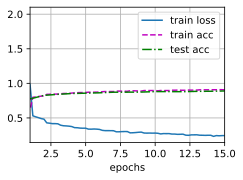

In [44]:
lr , num_epochs = 0.01 , 15
train_ch6( lenet , train_iter , test_iter , lr , num_epochs , try_gpu() )

In [3]:
50*256 , len(train_iter) , 235*256

(12800, 235, 60160)